In [60]:
### TO RUN
import os
from sklearn.ensemble import RandomForestClassifier

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS
from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.layers import Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping


In [61]:
np.random.seed(0)

Useful functions to select, read and play the dataset sounds are provided in ``classification/utils/audio_student.py``. <br>

As for the H1, you will have to fill some short pieces of code, as well as answer some questions. We already created cells for you to answer the questions to ensure you don't forget it ;). <br>
You will find the zones to be briefly filled  with a ``### TO COMPLETE`` in the cells below.

<font size=6 color=#009999> 2. Training and Evaluating models on audio signals [~1h30-2h] </font> <br>

In [62]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))
print(len(classnames))

{'chainsaw': [PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_000.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_001.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_010.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_011.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_020.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_021.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_030.wav'), PosixPath('/home/ulysse/Documents/LELEC21023-grH/classification/src/classification/datasets/soundfiles/chainsaw_031.wav'), Po

In [63]:
### TO RUN
fm_dir = "../../feature_mat/"  # where to save the features matrices
model_dir = "data/models/"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In H1, it was not made explicit what we choose as input for the classification model, a.k.a. ``feature vector`` (it was shown in the illustration). <br>
The objective is, on the transmitter side, to compute a feature vector containing enough information about the audio signal we want to classify, but not too much in order to limit the data which has to be transmitted wirelessly. This is why in H1 we implemented the ``Hz2Mel`` conversion: a very simple compression of the frequency content. <br>
The feature vector we will use here simply consists in taking the first 20 columns of the melspectrogram, corresponding to ~1s, then reshaping it as a vector. This means each feature vector contains ``400`` coefficients, with 20 columns of 20 mels each.  <br>

Once the feature vector has been recovered on the receiver side, we can apply any computation on it to guess the right class this sound belongs to. Today, we will simply reuse the simple KNN and LDA classifiers and look at what we already get. 

<font size=3 color=#FF0000> Important :</font> <br>
The analyses that follow are given as food for thoughts. They are not given as step by step improvements of the classifier.

<font size=5 color=#009999> 2.1. Creation of the dataset </font> <br>

``Feature_vector_DS`` is a class defined in ``classification/utils/audio_student.py``. <br>
The functions ``__len__`` and ``__getitem__`` are implemented, meaning you can call :
- ``len(myds)`` to get the number of sounds in it.
- ``myds[classname,j]`` to get the melspectrogram of the ``j``-th sound from class ``classname``. <br>

Two other useful functions are provided:
- ``get_audiosignal`` returning the temporal audiosignal at the specified index.
- ``display`` playing the sound and showing the associated mel-spectrogram at the specified index.

<font size=3 color=#FF0000> Important :</font> <br>
Before being able to run the cells below, you will have to reuse your functions from H1 to fill the missing lines in ``audio_student.py`` at ``###TO COMPLETE`` locations.

In [64]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950 )

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

# idx = 10
# myds.display(["chainsaw", idx])


# idx = 1
# myds.display(["fireworks", idx])
# print(myds["fire", 0])

20

Running the cell above many times, you should notice it is always the beginning of the sound that is taken for creating the feature vector. ``shift_pct`` meaning *shift percentage* allows to roll the audio signal with a random factor upper bounded by this value. Change ``shift_pct`` to ``0.2`` and observe what happens.

In [65]:
### TO RUN
"Random split of 70:30 between training and validation"
train_pct = 0.7
featveclen = len(myds["fire", 0])  # number of items in a feature vector
# print(f"Feature vector length: {featveclen}")
nitems = len(myds)  # number of sounds in the dataset
naudio = dataset.naudio  # number of audio files in each class
nclass = dataset.nclass  # number of classes
data_aug_factor = 1
naudio_sum = sum(naudio.values())
class_ids_aug = np.concatenate(
    [np.repeat(classname, naudio[classname] * data_aug_factor) for classname in classnames]
)

X = np.zeros((data_aug_factor * naudio_sum, featveclen))
for s in range(data_aug_factor):
    for class_idx, classname in enumerate(classnames):
        for idx in range(naudio[classname]):
            featvec = myds[classname, idx]
            X[s * nclass * naudio[classname] + class_idx * naudio[classname] + idx, :] = featvec
np.save(fm_dir + "feature_matrix_2D.npy", X)
# Assuming classnames is already defined

# Print the names of the classes
print("Class names:", classnames)


X = np.load(fm_dir+"feature_matrix_2D.npy")

"Labels"
y = class_ids_aug.copy()
classnames = np.unique(y)

print(f"Shape of the feature matrix : {X.shape}")
print(f"Number of labels : {len(y)}")
unique_classes, class_counts = np.unique(y, return_counts=True)

# Print the counts for each class
for classname, count in zip(unique_classes, class_counts):
    print(f"Class '{classname}': {count} samples")


Class names: ['chainsaw', 'fire', 'fireworks', 'gun']
Shape of the feature matrix : (254, 400)
Number of labels : 254
Class 'chainsaw': 80 samples
Class 'fire': 59 samples
Class 'fireworks': 75 samples
Class 'gun': 40 samples


You might notice that ``feature_matrix_2D.npy`` has been saved in ``data/feature_matrices/`` and can now be loaded instead of recomputing it at every run.

<font size=5 color=#009999> 2.2. First audio classification, metrics and dataset splitting </font> <br>

For now we have only prepared the dataset, it remains to feed it to the classifiers. <br>

In [66]:
n = 14  # Number of principal components kept
model_pca = PCA(n_components=n, whiten=True)
# [4] Model training and selection.
K = 8
model_knn = KNeighborsClassifier(n_neighbors=K, weights="distance")

model_rf = RandomForestClassifier(n_estimators=100, 
                             max_depth=2,
                             min_impurity_decrease=0.01
                             ,min_samples_leaf=2,
                             min_samples_split=3,
                             random_state=0)
model_lda = LDA(
    solver="svd",
    shrinkage=None,
    priors=None,
    n_components=None,
    store_covariance=False,
    tol=0.0001,
    covariance_estimator=None,
) 



As for the toy example, we keep the ``accuracy`` and ``confusion matrix`` as performance metrics. <br>

Note that here we are not especially interested in a model selection hence we only split the dataset in training and testing parts but we don't split the training set in learning/validation parts. The models are trained on the entire training set.

<font size=5 color=#009999> 2.6. Augmenting the data </font> <br>

In order to make our classifier more robust to some common transformations of the audio signal such as ``time shift``, ``AWGN``, or a ``transfer function``, an idea consists in feeding the classifier with such transformations. A popular approach is to create new feature vectors based on transformed versions of the sounds from the original dataset, this is called ``data augmentation``. Data augmentation is also often used when there is few data to train a model. <br>

The functions to augment your data are written in ``utils/audio_student.py``, we already implemented ``time_shift``, ``echo`` and ``spectro_aug_timefreq_masking`` for you. Try to implement ``scaling``, ``add_noise``, ``filter``, ``add_bg`` and even more data augmentation techniques if you want, and check their working in the cell below. <br>

<u>Tip</u>: to avoid restarting the notebook kernel for each modification, you can temporarily insert the ``AudioUtil`` class in a new cell and make your tests until it is working as expected. 

ALSA lib pcm.c:8568:(snd_pcm_recover) underrun occurred


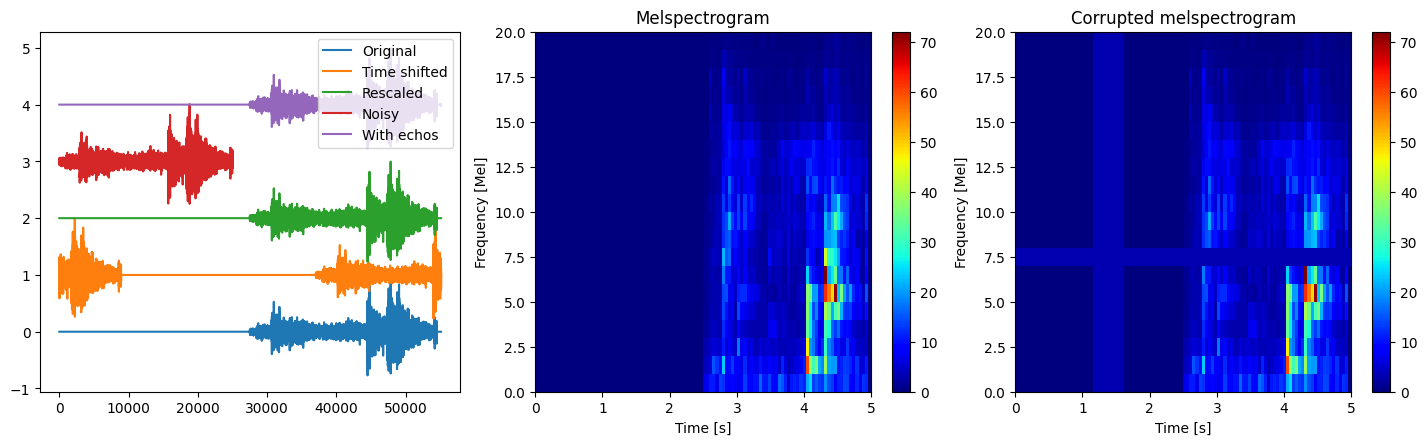

In [67]:
### TO RUN
myds.data_aug = None  # Ensure

cls_index = ["fire", 2]

sound = dataset.__getitem__(cls_index)
name = dataset.__getname__(cls_index)
audio = AudioUtil.open(sound)
audio_tmp = AudioUtil.open(sound)
AudioUtil.play(audio)
audio2 = AudioUtil.resample(audio, 11025)
audio2 = AudioUtil.pad_trunc(audio2, 5000)

audio3 = AudioUtil.time_shift(audio2, 0.5)
audio4 = AudioUtil.scaling(audio2)
audio5 = AudioUtil.add_noise(audio_tmp, sigma=1e-4)  # Create a copy before adding noise
audio6 = AudioUtil.echo(audio2)
# audio7 = AudioUtil.add_bg(audio2, dataset)

melspec = AudioUtil.melspectrogram(audio2, fs2=11025)
melspec2 = AudioUtil.spectro_aug_timefreq_masking(melspec, max_mask_pct=0.1)

"Plot"
fig = plt.figure(figsize=(15, 4))
ax1 = fig.add_axes([0.05, 0.05, 0.28, 0.9])
ax2 = fig.add_axes([0.38, 0.05, 0.28, 0.9])
ax3 = fig.add_axes([0.7, 0.05, 0.28, 0.9])

ax1.plot(audio2[0], label="Original")
ax1.plot(audio3[0] + 1, label="Time shifted")
ax1.plot(audio4[0] + 2, label="Rescaled")
ax1.plot(audio5[0] + 3, label="Noisy")
ax1.plot(audio6[0] + 4, label="With echos")
# ax1.plot(audio7[0] + 5, label="With background sound")
ax1.legend()

plot_specgram(melspec, ax2, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax2.set_title("Melspectrogram")
plot_specgram(melspec2, ax3, is_mel=True, title=name, tf=len(audio2[0]) / audio2[1])
ax3.set_title("Corrupted melspectrogram")
plt.show()

We can now create a new augmented dataset and observe if the classification results improve. 

In [71]:
from tqdm import tqdm

### TO RUN
# Initialize the feature matrices and labels for different Nft values

Nft_values = np.arange(320,720,1)  # List of Nft values
X_aug_dict = {}
y_aug_dict = {}

naudio_sum = sum(naudio.values())
for Nft in tqdm(Nft_values, desc="Processing Nft values"):
    # Create a Feature_vector_DS for the current Nft with shift_pct = 0
    myds_shifted = Feature_vector_DS(dataset, Nft=Nft, nmel=20, duration=950, shift_pct=0)
    
    # Initialize feature matrix and labels for the current Nft
    X_aug_shifted = np.zeros((myds_shifted.data_aug_factor * naudio_sum, len(myds_shifted["fire", 0])))
    y_aug_shifted = np.empty((myds_shifted.data_aug_factor * naudio_sum), dtype=object)
    
    # Generate feature vectors and labels
    for s in range(myds_shifted.data_aug_factor):
        offset = 0
        for class_idx, classname in enumerate(classnames):
            num_samples = naudio[classname]  # Number of samples for the current class
            for idx in range(num_samples):
                featvec = myds_shifted[classname, idx]
                X_aug_shifted[s * naudio_sum + offset + idx, :] = featvec
                y_aug_shifted[s * naudio_sum + offset + idx] = classname
            offset += num_samples  # Update the offset for the next class
    
    # Save the feature matrices and labels for the current Nft
    np.save(fm_dir + f"feature_matrix_2D_Nft_{Nft}.npy", X_aug_shifted)
    np.save(fm_dir + f"labels_2D_Nft_{Nft}.npy", y_aug_shifted)
    
    # Store the datasets in the dictionary
    X_aug_dict[Nft] = X_aug_shifted
    y_aug_dict[Nft] = y_aug_shifted

# Print summary of the datasets
for Nft in Nft_values:
    print(f"Nft={Nft}: Feature matrix shape: {X_aug_dict[Nft].shape}, Number of labels: {len(y_aug_dict[Nft])}")


Processing Nft values: 100%|██████████| 400/400 [03:42<00:00,  1.79it/s]

Nft=320: Feature matrix shape: (254, 640), Number of labels: 254
Nft=321: Feature matrix shape: (254, 640), Number of labels: 254
Nft=322: Feature matrix shape: (254, 640), Number of labels: 254
Nft=323: Feature matrix shape: (254, 640), Number of labels: 254
Nft=324: Feature matrix shape: (254, 640), Number of labels: 254
Nft=325: Feature matrix shape: (254, 640), Number of labels: 254
Nft=326: Feature matrix shape: (254, 640), Number of labels: 254
Nft=327: Feature matrix shape: (254, 640), Number of labels: 254
Nft=328: Feature matrix shape: (254, 620), Number of labels: 254
Nft=329: Feature matrix shape: (254, 620), Number of labels: 254
Nft=330: Feature matrix shape: (254, 620), Number of labels: 254
Nft=331: Feature matrix shape: (254, 620), Number of labels: 254
Nft=332: Feature matrix shape: (254, 620), Number of labels: 254
Nft=333: Feature matrix shape: (254, 620), Number of labels: 254
Nft=334: Feature matrix shape: (254, 620), Number of labels: 254
Nft=335: Feature matrix s

<font size=5 color=#009999> 2.7. Getting it all together </font> <br>

Now that some aspects to be considered during the model training and analysis have been presented, it remains to train and save a final model that will be used for further predictions.

In [72]:
for Nft in Nft_values:
    print(f"Processing Nft={Nft}...")

    # Load the feature matrix and labels for the current Nft
    X_aug = np.load(fm_dir + f"feature_matrix_2D_Nft_{Nft}.npy")
    y_aug = np.load(fm_dir + f"labels_2D_Nft_{Nft}.npy", allow_pickle=True)

    # Normalize the feature matrix
    X_aug = X_aug / np.linalg.norm(X_aug, axis=1, keepdims=True)

    # Split the dataset into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(
        X_aug, y_aug, test_size=0.3, stratify=y_aug
    )

    # # Apply PCA
    # pca = PCA(n_components=25, whiten=True)
    # X_train = pca.fit_transform(X_train)
    # X_test = pca.transform(X_test)

    # # Save the PCA model
    # filename_pca = f"pca_25_components_Nft_{Nft}.pickle"
    # pickle.dump(pca, open(model_dir + filename_pca, "wb"))

    # Train the Random Forest model
    best_rf = RandomForestClassifier(
    )

    n_splits = 5
    kf = StratifiedKFold(n_splits=n_splits, shuffle=True)
    accuracies_rf = np.zeros((n_splits,))

    for k, idx in enumerate(kf.split(X_train, y_train)):
        idx_learn, idx_val = idx
        best_rf.fit(X_train[idx_learn], y_train[idx_learn])
        prediction_rf = best_rf.predict(X_train[idx_val])
        accuracies_rf[k] = accuracy_score(y_train[idx_val], prediction_rf)

    # Save the trained model
    filename_model = f"best_rf_model_Nft_{Nft}.pickle"
    pickle.dump(best_rf, open(model_dir + filename_model, "wb"))

    # Evaluate the model
    print(f"Mean accuracy with Random Forest 5-Fold CV for Nft={Nft}: {100 * accuracies_rf.mean():.1f}%")
    print(f"Std deviation in accuracy with 5-Fold CV for Nft={Nft}: {100 * accuracies_rf.std():.1f}%")

    y_pred = best_rf.predict(X_test)
    accuracy_rf = accuracy_score(y_test, y_pred)
    print(f"Test set accuracy with Random Forest for Nft={Nft}: {accuracy_rf * 100:.2f}%")
    
    # Show the confusion matrix
    # show_confusion_matrix(y_pred, y_test, classnames)


Processing Nft=320...
Mean accuracy with Random Forest 5-Fold CV for Nft=320: 83.1%
Std deviation in accuracy with 5-Fold CV for Nft=320: 6.7%
Test set accuracy with Random Forest for Nft=320: 75.32%
Processing Nft=321...
Mean accuracy with Random Forest 5-Fold CV for Nft=321: 84.8%
Std deviation in accuracy with 5-Fold CV for Nft=321: 3.7%
Test set accuracy with Random Forest for Nft=321: 71.43%
Processing Nft=322...
Mean accuracy with Random Forest 5-Fold CV for Nft=322: 79.6%
Std deviation in accuracy with 5-Fold CV for Nft=322: 6.7%
Test set accuracy with Random Forest for Nft=322: 75.32%
Processing Nft=323...
Mean accuracy with Random Forest 5-Fold CV for Nft=323: 81.4%
Std deviation in accuracy with 5-Fold CV for Nft=323: 5.7%
Test set accuracy with Random Forest for Nft=323: 85.71%
Processing Nft=324...
Mean accuracy with Random Forest 5-Fold CV for Nft=324: 83.7%
Std deviation in accuracy with 5-Fold CV for Nft=324: 9.1%
Test set accuracy with Random Forest for Nft=324: 79.22%
